In [1]:
import sys

sys.path.append("../libs")

CONFIG = {
    "cleaned_dataset": "lending_club_cleaned",
    "feature_dataset_database_file": "../data/feature_store.db",
    "dfs_agg_primitives" : ["mean", "sum", "count", "max", "min", "std"],
    "train_size": 0.75,
    "test_size": 0.15,
    "val_size": 0.10,
    "target": "default",
    "features_to_remove": ['loan_status', 'int_rate', 'debt_settlement_flag']
}

### Loading Data

In [2]:
from feature_dataset import FeatureDataset

fs = FeatureDataset(CONFIG['feature_dataset_database_file'])
df = fs.get_feature_dataset(name=CONFIG['cleaned_dataset'])
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,hardship_flag,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,default
0,1077501,5000,5000,36,0.106506,162.87500,10+ years,RENT,24000.0,Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
1,1077430,2500,2500,60,0.152710,59.84375,< 1 year,RENT,30000.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,1.0
2,1077175,2400,2400,36,0.159546,84.31250,10+ years,RENT,12252.0,Not Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
3,1076863,10000,10000,36,0.134888,339.25000,10+ years,RENT,49200.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
4,1075358,3000,3000,60,0.126953,67.81250,1 year,RENT,80000.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0


In [3]:
df_training = df[df[CONFIG["target"]].notnull()]
features_to_remove = [CONFIG["target"]] + CONFIG["features_to_remove"]
print(f"Features to remove: {features_to_remove}")

Features to remove: ['default', 'loan_status', 'int_rate', 'debt_settlement_flag']


In [4]:
X = df_training.drop(columns=features_to_remove)

### Generation Features



In [5]:
from processing.deep_feature_synthesis import DeepFeatureSynthesisPipeline
deep_feature_synthetic = DeepFeatureSynthesisPipeline(name="loan_data", aggs_primitives=CONFIG['dfs_agg_primitives'])


In [ ]:
X = deep_feature_synthetic.transform(X)


In [7]:
cat_features = list(X.select_dtypes(include=['category']).columns)
X[cat_features] = X[cat_features].astype(str).fillna('missing')
y = df_training[CONFIG["target"]]

### Split Data

In [8]:
from processing.data_splitter import DataSplitter
splitter = DataSplitter(train_size=CONFIG['train_size'], test_size=CONFIG['test_size'], val_size=CONFIG['val_size'])
X_train, X_test, X_val, y_train, y_test, y_val = splitter.split_data(X, y)


In [11]:
import pandas as pd
df_training = pd.concat([X_train, y_train], axis=1)
df_testing = pd.concat([X_test, y_test], axis=1)
df_validation = pd.concat([X_val, y_val], axis=1)


In [12]:
fs.create_feature_dataset(name="training",dataset=df_training, version=1)
fs.create_feature_dataset(name="validation",dataset=df_validation, version=1)
fs.create_feature_dataset(name="testing",dataset=df_testing, version=1)

In [112]:
df_training = df[df['default'].notnull()]
X = df_training.drop(columns=['default', 'loan_status', 'int_rate'])
cat_features = list(X.select_dtypes(include=['category']).columns)
X, feature_defs = run_feature_selection(X)
X[cat_features] = X[cat_features].astype(str).fillna('missing')
y = df_training['default']


/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/featuretools/entityset/entityset.py:1717: UserWarning: Using first column as index. To change this, specify the index parameter
  warnings.warn(
/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/woodwork/logical_types.py:841: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  series = series.replace(ww.config.get_option("nan_values"), np.nan)
/Users/

Built 105 features
Elapsed: 00:14 | Progress: 100%|██████████


### Save Dataset

In [145]:

X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, train_size=0.75, test_size=0.15, val_size=0.10)
df_training = pd.concat([X_train, y_train], axis=1)
df_testing = pd.concat([X_test, y_test], axis=1)
df_validation = pd.concat([X_val, y_val], axis=1)


In [9]:
fs.create_feature_dataset(name="training",dataset=df_training, version=1)
fs.create_feature_dataset(name="validation",dataset=df_validation, version=1)
fs.create_feature_dataset(name="testing",dataset=df_testing, version=1)

NameError: name 'df_validation' is not defined

In [119]:
from catboost import CatBoostClassifier

# Using PRAUC Use Weights False to not inflat the PRAUC metric
baseline_params = {
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'PRAUC:use_weights=false',
    'cat_features': list(cat_features),
    'verbose': True,
    'random_seed': 55,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'learning_rate': 0.02,
    # 'bootstrap_type': 'Bernoulli',  # Alterar o tipo de bootstrap para Bernoulli
    'early_stopping_rounds': 100
}
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred_baseline = model.predict_proba(X_val)[:, 1]

Traning the model...
0:	learn: 0.8149809	test: 0.8141959	best: 0.8141959 (0)	total: 654ms	remaining: 10m 53s
1:	learn: 0.8266074	test: 0.8254849	best: 0.8254849 (1)	total: 1.15s	remaining: 9m 34s
2:	learn: 0.8277312	test: 0.8269447	best: 0.8269447 (2)	total: 1.55s	remaining: 8m 35s
3:	learn: 0.8273241	test: 0.8262428	best: 0.8269447 (2)	total: 1.98s	remaining: 8m 12s
4:	learn: 0.8286072	test: 0.8276672	best: 0.8276672 (4)	total: 2.48s	remaining: 8m 13s
5:	learn: 0.8287188	test: 0.8278105	best: 0.8278105 (5)	total: 2.92s	remaining: 8m 4s
6:	learn: 0.8288343	test: 0.8280105	best: 0.8280105 (6)	total: 3.38s	remaining: 7m 59s
7:	learn: 0.8294492	test: 0.8286287	best: 0.8286287 (7)	total: 3.76s	remaining: 7m 46s
8:	learn: 0.8292492	test: 0.8284859	best: 0.8286287 (7)	total: 4.15s	remaining: 7m 37s
9:	learn: 0.8292526	test: 0.8285161	best: 0.8286287 (7)	total: 4.53s	remaining: 7m 28s
10:	learn: 0.8296730	test: 0.8290483	best: 0.8290483 (10)	total: 5.05s	remaining: 7m 34s
11:	learn: 0.8296490

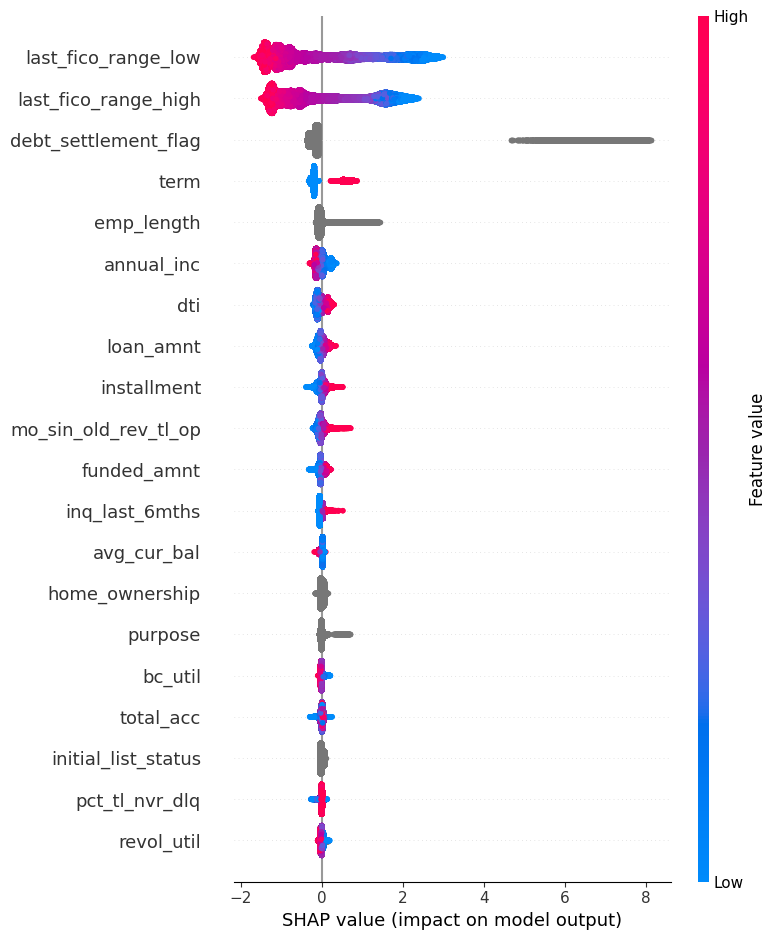

In [120]:
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap

shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_val)
shap.summary_plot(shap_values, X_val)

In [121]:
selected_features = None

In [122]:
X_train

,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,...,sec_app_collections_12_mths_ex_med,hardship_flag,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
id,,,,,,,,,,,,,,,,,,,,,
4280825,6000,6000,36,187.000,3 years,MORTGAGE,58000.0,Verified,car,LA,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
114813959,14000,14000,36,555.500,10+ years,MORTGAGE,200000.0,Verified,debt_consolidation,CT,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
46349285,20000,20000,60,563.500,nan,MORTGAGE,65000.0,Verified,debt_consolidation,PA,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
101482465,10000,10000,36,339.250,5 years,RENT,60000.0,Not Verified,debt_consolidation,TX,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
10844710,7500,7500,36,249.125,1 year,MORTGAGE,75000.0,Source Verified,debt_consolidation,NY,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116547676,25000,25000,60,608.000,10+ years,MORTGAGE,75000.0,Source Verified,debt_consolidation,NY,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
104025428,5000,5000,36,192.875,5 years,RENT,43258.0,Source Verified,debt_consolidation,AZ,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N
4569000,28000,28000,36,958.000,8 years,MORTGAGE,79800.0,Verified,debt_consolidation,TX,...,-1,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N


In [123]:
list(cat_features)

['emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [124]:
feat_selection_params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False
}


model_for_feat_selection = CatBoostClassifier(**feat_selection_params)

feat_selector = arfsgroot.Leshy(
    model_for_feat_selection, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/arfs/feature_selection/allrelevant.py:325: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")
/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Leshy iteration: 100%|██████████| 10/10 [04:51<00:00, 29.19s/it]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	68
Tentative: 	14
Rejected: 	14
All relevant predictors selected in 00:04:52.29


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x6bf0c63d0>,
      max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x8802A7340, verbose=1)

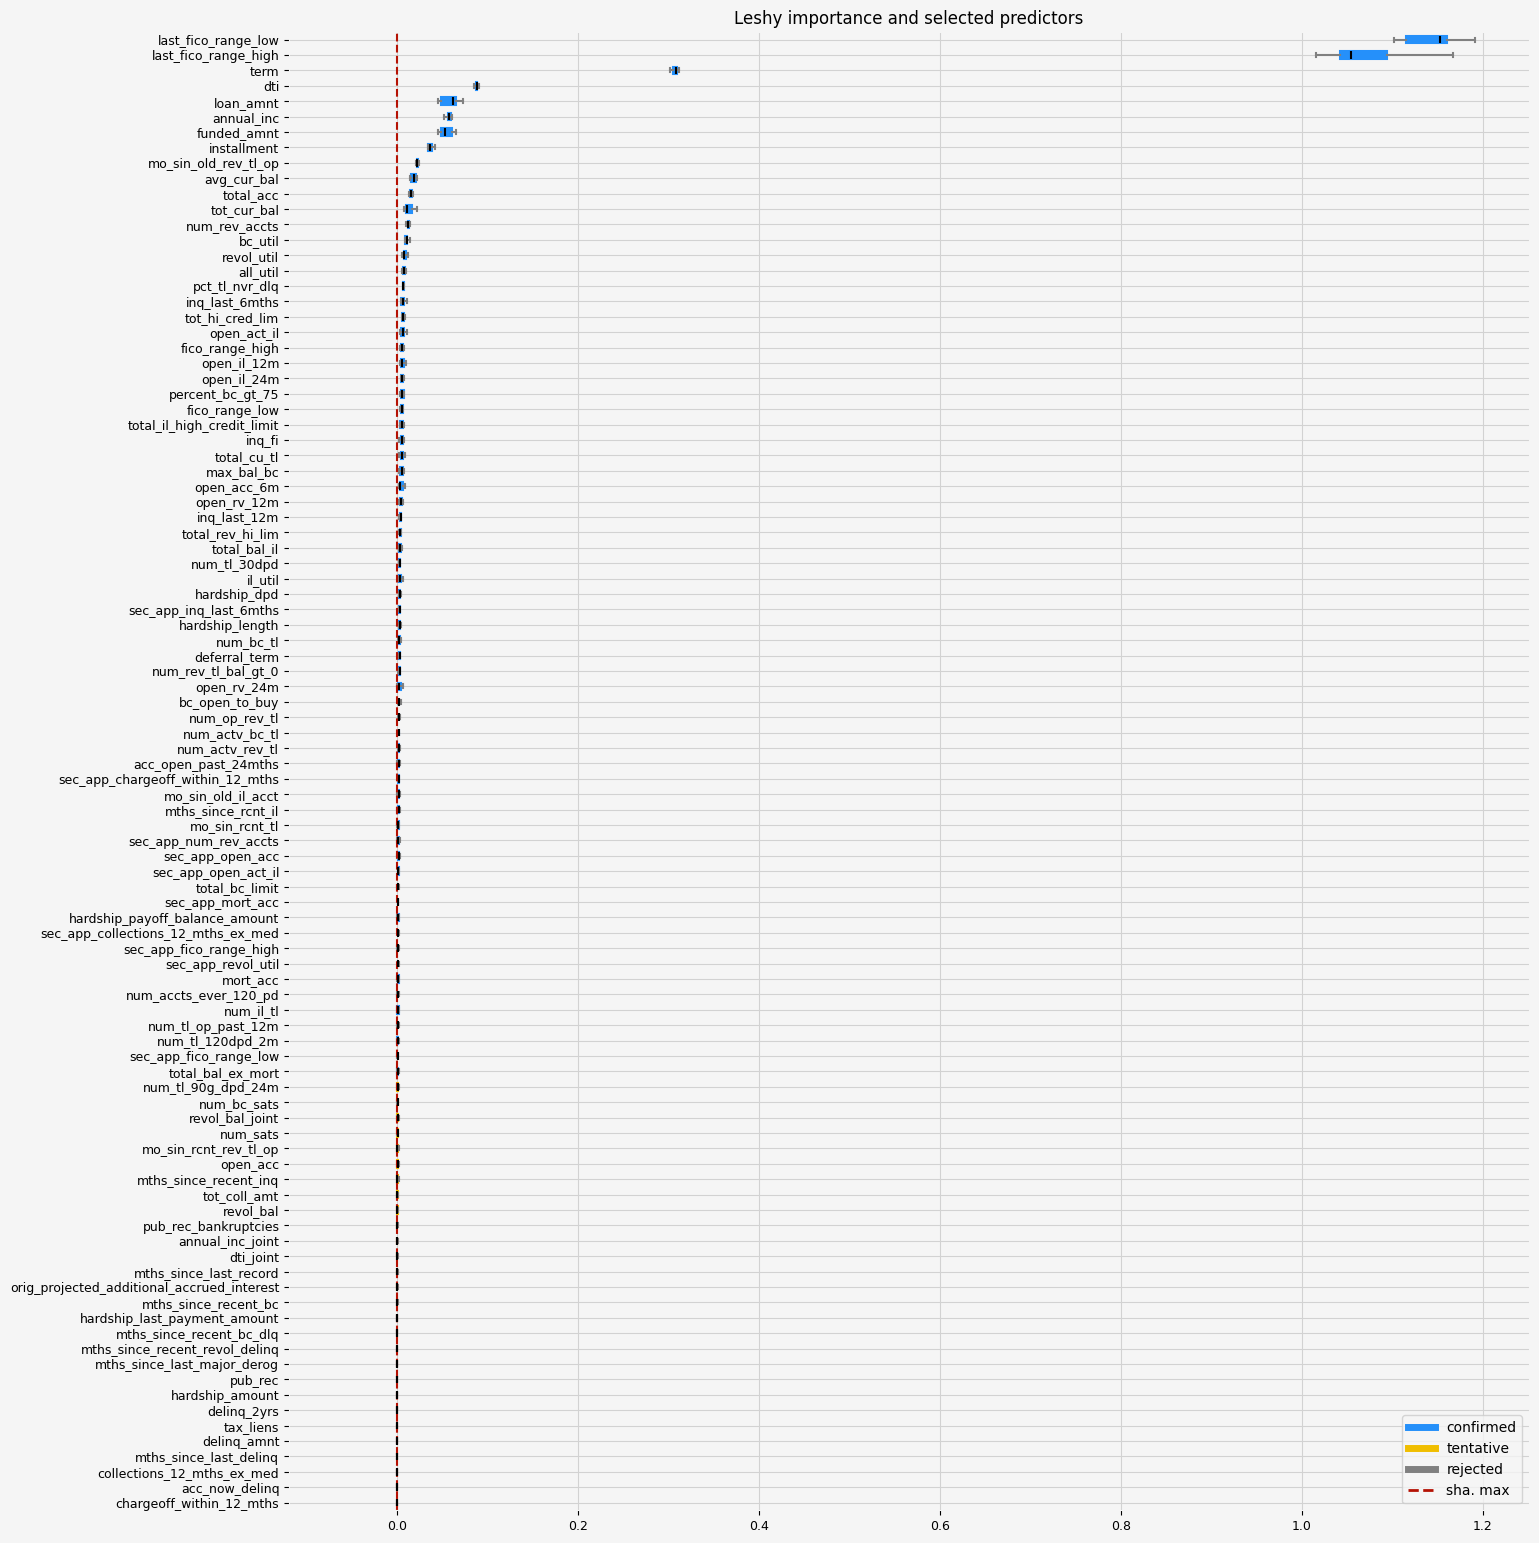

In [127]:
_ = feat_selector.plot_importance()


In [130]:
len(feat_selector.get_feature_names_out().tolist())

68

In [131]:
import json
import os

selected_features = feat_selector.get_feature_names_out().tolist() + list(cat_features)

# Ensure the directory exists
os.makedirs('../data/model', exist_ok=True)

# Save the selected features
with open('../data/model/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

In [105]:
selected_features

['loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'revol_bal',
 'revol_util',
 'total_acc',
 'last_fico_range_high',
 'last_fico_range_low',
 'annual_inc_joint',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_tl',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 're

In [132]:
model_selected = CatBoostClassifier(**baseline_params)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_val[selected_features], y_val), early_stopping_rounds=200, verbose=True)

y_pred_selected = model_selected.predict_proba(X_val[selected_features])[:, 1]

0:	learn: 0.8246165	test: 0.8238621	best: 0.8238621 (0)	total: 416ms	remaining: 6m 55s
1:	learn: 0.8285588	test: 0.8276942	best: 0.8276942 (1)	total: 888ms	remaining: 7m 23s
2:	learn: 0.8294340	test: 0.8284773	best: 0.8284773 (2)	total: 1.23s	remaining: 6m 47s
3:	learn: 0.8284228	test: 0.8274261	best: 0.8284773 (2)	total: 1.52s	remaining: 6m 19s
4:	learn: 0.8301077	test: 0.8291800	best: 0.8291800 (4)	total: 1.91s	remaining: 6m 19s
5:	learn: 0.8308314	test: 0.8299501	best: 0.8299501 (5)	total: 2.31s	remaining: 6m 23s
6:	learn: 0.8315283	test: 0.8307402	best: 0.8307402 (6)	total: 2.63s	remaining: 6m 12s
7:	learn: 0.8321464	test: 0.8314622	best: 0.8314622 (7)	total: 3.01s	remaining: 6m 13s
8:	learn: 0.8321600	test: 0.8314091	best: 0.8314622 (7)	total: 3.38s	remaining: 6m 12s
9:	learn: 0.8321614	test: 0.8313712	best: 0.8314622 (7)	total: 3.77s	remaining: 6m 12s
10:	learn: 0.8318054	test: 0.8310667	best: 0.8314622 (7)	total: 4.11s	remaining: 6m 9s
11:	learn: 0.8319440	test: 0.8311571	best: 

In [134]:
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter

def clf_metric_report(y_score, y_true):
    print('Evaluating the model...')
    roc_auc = roc_auc_score(y_true, y_score)
    brier = brier_score_loss(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    logloss = log_loss(y_true, y_score)
    print(f'ROC AUC: {roc_auc}')
    print(f'Brier Score: {brier}')
    print(f'Average Precision: {avg_precision}')
    print(f'Log Loss: {logloss}')

def compute_and_plot_permutation_importance(model, X_test, y_test, metric='average_precision', n_repeats=5):
    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=42, scoring=metric)
    features = X_test.columns.to_list()

    # Sort features by importance
    feature_importance = pd.DataFrame({'feature': features, 'importance': result.importances_mean})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Plot top 20 most important features using seaborn
    plt.figure(figsize=(10, 12))
    sns.barplot(data=feature_importance, y='feature', x='importance')
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    return feature_importance

def plot_calibration_curve(y_score, y_true, title='Calibration Curve'):
    prob_true, prob_pred = calibration_curve(y_score, y_true, n_bins=10)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(title)
    plt.show()

def plot_pr_calib_curve(y_score, y_true):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.subplot(1, 2, 2)
    plt.plot(prob_pred, prob_true, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')

    plt.tight_layout()
    plt.show()

def plot_dis_probs(y_score, y_true):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_score[y_true == 1], bins=50, color='red', label='Default', kde=True, stat='density')
    sns.histplot(y_score[y_true == 0], bins=50, color='blue', label='Non-Default', kde=True, stat='density')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for Default vs Non-Default')
    plt.legend()
    plt.show()


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    round_to = 3
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True house prices in $")
    axs.set_ylabel("Prediction of house prices in $")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

def plot_shap_values(shap_values, X_test, figsize=(10, 12), type='bar'):
    #plt.figure(figsize=figsize)
    shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=25)

In [135]:
clf_metric_report(y_pred_baseline, y_val)


Evaluating the model...
ROC AUC: 0.9540427921509772
Brier Score: 0.0865139704007022
Average Precision: 0.8477355375595126
Log Loss: 0.2764109802835969


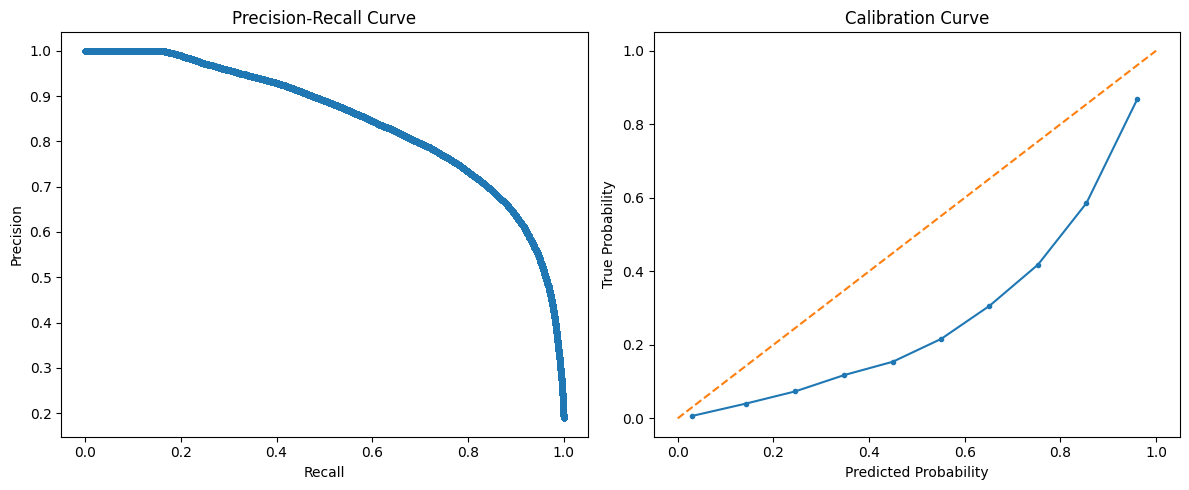

In [136]:
plot_pr_calib_curve(y_pred_baseline, y_val)


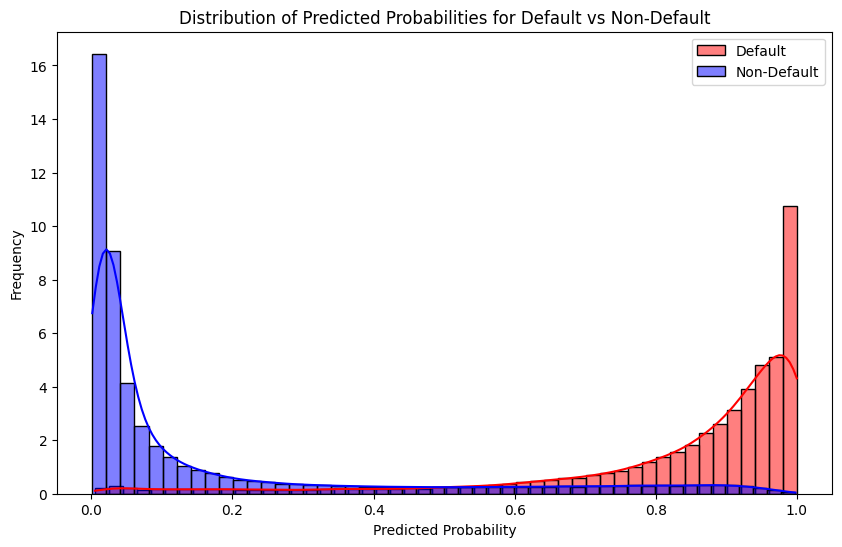

In [137]:
plot_dis_probs(y_pred_baseline, y_val)


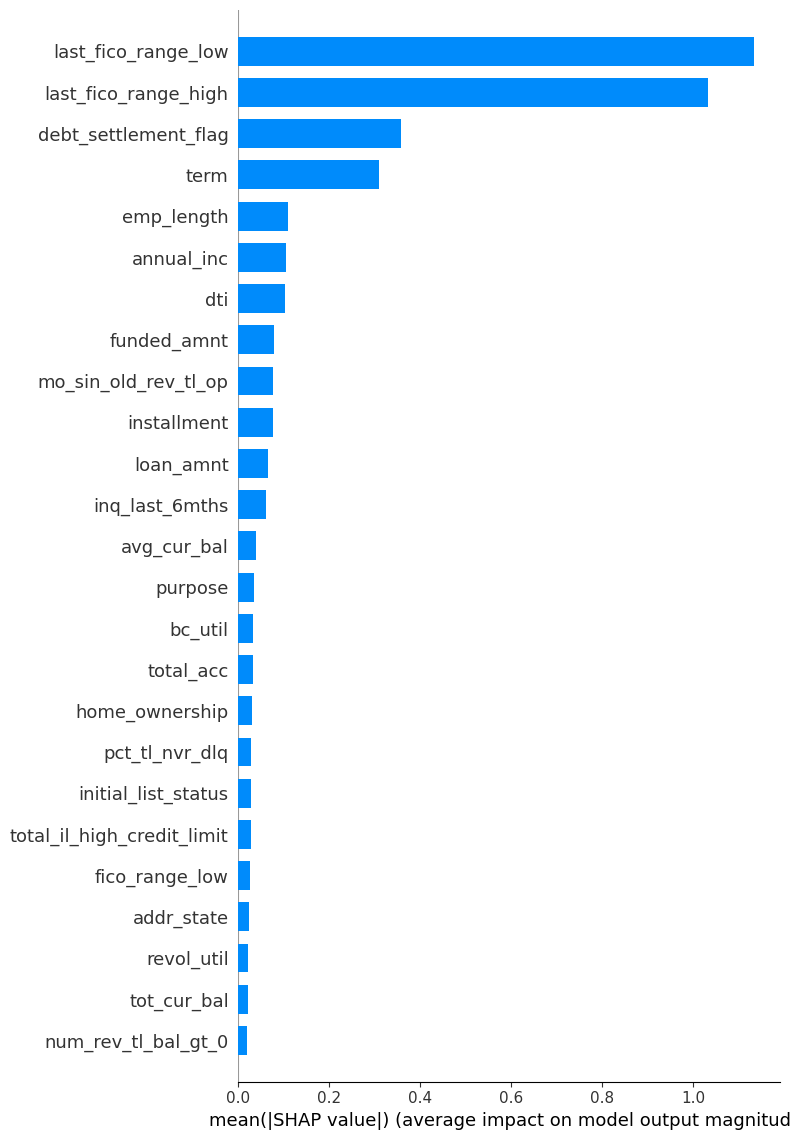

In [138]:
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_val[selected_features])
plot_shap_values(shape_values, X_val[selected_features], y_val)

In [139]:
print('Baseline model')
clf_metric_report(y_pred_baseline, y_val)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_val)
print('')

Baseline model
Evaluating the model...
ROC AUC: 0.9540427921509772
Brier Score: 0.0865139704007022
Average Precision: 0.8477355375595126
Log Loss: 0.2764109802835969

Feature selection model
Evaluating the model...
ROC AUC: 0.9538134602597317
Brier Score: 0.08673857030415706
Average Precision: 0.8470426018387816
Log Loss: 0.2770904083974146



In [141]:
print('Average precision improvement: ', (average_precision_score(y_val, y_pred_selected) - average_precision_score(y_val, y_pred_baseline)) / average_precision_score(y_val, y_pred_baseline))


Average precision improvement:  -0.0008173960982287954


In [143]:
import joblib
# Save the baseline model
baseline_model_path = '../data/model/baseline_model.joblib'
joblib.dump(model, baseline_model_path)

# Save the model trained with selected features
feat_selection_model_path = '../data/model/feat_selection_model.joblib'
joblib.dump(model_selected, feat_selection_model_path)

print(f"Baseline model saved to: {baseline_model_path}")
print(f"Baseline model saved to: {feat_selection_model_path}")

Baseline model saved to: ../data/model/baseline_model.joblib
Baseline model saved to: ../data/model/feat_selection_model.joblib
